In [127]:
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from multiprocessing import Pool


import torchvision
from torchvision import models as tvmodels
from torchsummary import summary

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision.models as torchvisionmodels

import os
import numpy as np
import cv2
import argparse
import sys

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import itertools
import more_itertools

import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from captum.attr import LayerGradCam
from captum.attr import visualization
from PIL import Image
import shutil

import numpy as np
from dask_image.imread import imread
from dask_image import ndfilters, ndmorph, ndmeasure
import matplotlib.pyplot as plt
from dask_image import ndmeasure

from operator import itemgetter

In [128]:
from model import resnet
from model.utils import load_filtered_state_dict, SaveBestModel, AverageMeter, accuracy
model = resnet.ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 2)
checkpoint = torch.load('trained_models/cyberbullying/epoch_8.pkl')
load_filtered_state_dict(model, checkpoint, ignore_layer=[], reverse=True)
transform_test = transforms.Compose([transforms.Resize(320),
        transforms.RandomCrop(299), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

good_img_transform = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classes = {0:'cyberbullying', 1:'non_cyberbullying'}

test_path = '../cyberbullying_purification/samuel_src/datasets/cyberbullying/test'
testset = torchvision.datasets.ImageFolder(test_path, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=True, num_workers=2)

model.to(device)
model.eval()
print("Model and data loaded")
#model.load_state_dict(checkpoint, strict=False)

320 320
Model and data loaded


In [129]:
# This is to reverse the normalization done to the images that centered them around imagenet mean and std
# The invTrans should be used on images before saving them.
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [130]:
from skimage import segmentation
from pytorch_grad_cam import XGradCAM, GradCAM, FullGrad, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [131]:
def get_grayscale_grad_cam(image):
    input_tensor = image.to(device)
    targets = [ClassifierOutputTarget(0)]
    #target_layers = [model.layer4[-1]]
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    return(grayscale_cam)

def segmentation_info(image, num_segments, compactness):
    img_np = image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    segments_slic = slic(img_np, n_segments = num_segments, compactness=compactness,
                     start_label=1)
    num_segments = len(np.unique(segments_slic))
    list_unique_regions = np.unique(segments_slic)
    segment_pixel_num_list = []
    total_pixels = 0
    for i in (list_unique_regions):
        num_pixels = np.count_nonzero(segments_slic == i)
        segment_pixel_num_list.append(num_pixels)
        total_pixels += num_pixels
    
    
    information_for_each_segment = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(segment_pixel_num_list[i-1])
        image_list.append(total_pixels)
        information_for_each_segment.append(image_list)

    return(information_for_each_segment, segments_slic, num_segments)


# I want to get the average attribution score for each segment
def cam_processor_for_segments(grayscale_cam_output, segments_slic):
    
    
    
    list_unique_regions = np.unique(segments_slic)
    region_attr_score = []
    final_region_attr_score = []
    num_pixels_in_region_list = []
    
    for i in (list_unique_regions):
        row_counter = 0
        column_counter = 0
        region_attr_score = []
        num_pixels_in_region = 0
        for row in grayscale_cam_output:
            for cell in row:
                current_score = grayscale_cam_output[row_counter, column_counter]
                current_region = segments_slic[row_counter, column_counter]
                if current_region == i:
                    region_attr_score.append(current_score)
                    num_pixels_in_region += 1
                column_counter +=1
            row_counter += 1
            column_counter = 0
        avg_score = np.mean(region_attr_score)
        final_region_attr_score.append(avg_score)
        num_pixels_in_region_list.append(num_pixels_in_region)
    
    unique_region_info = []
    for i in (list_unique_regions):
        image_list = []
        image_list.append(i)
        image_list.append(final_region_attr_score[i-1])
        image_list.append(num_pixels_in_region_list[i-1])
        image_list.append(np.sum(num_pixels_in_region_list))
        unique_region_info.append(image_list)
    
    return(unique_region_info)


def get_feature_masks(image, attributions, segments_slic):
    segments_slic_1 = segments_slic
    features = []
    for i in attributions:
        feature = np.where(i==segments_slic_1, 1, 0)
        features.append(feature)
        
    return(features)


def attribution_ranker(cam_processor_for_segments_output, num_top_attr):
    ranked_images = sorted(cam_processor_for_segments_output, key=itemgetter(1), reverse=True)
    top_ranked_features = []
    for i in range(num_top_attr):
        top_ranked_features.append(ranked_images[i][0])
        
    return top_ranked_features

def get_image_versions(image, features_list, model, SMU_class_index):
    image_versions = []
    num_pixels_changed = []
    total_attr_list = []

    powerset_list = list(more_itertools.powerset(features_list))
    powerset_list = [list(ele) for ele in powerset_list]
    num_versions = len(powerset_list)
    
    original_image = invTrans(image)
    image_versions.append(original_image)
    num_pixels_changed.append(0)
    total_attr_list.append(np.zeros((299, 299)))
    
    for version in range(num_versions - 1):
        obfuscated_image = image
        total_attribution = np.zeros((299, 299))
        total_num_pixels = total_attribution.size
        for mask in range(len(powerset_list[version + 1])):
            total_attribution += powerset_list[version + 1][mask]
            #print(np.max(powerset_list[version + 1][mask]))
        #print(np.max(total_attribution))
        num_changes = np.count_nonzero(total_attribution)
        num_pixels_changed.append(num_changes)
        total_attr_list.append(total_attribution)
        #print(num_changes)
        obfuscated_image = blur_image_from_attribution(image = obfuscated_image,
                                                       attribution_map = total_attribution)
        obfuscated_image = obfuscated_image.to(device)
        obfuscated_image = invTrans(obfuscated_image)
        
        image_versions.append(obfuscated_image)
    
    scores = []
    for i in range(num_versions):
        current_image = image_versions[i].to(device)
        #current_image = good_img_transform(current_image).to(device)
        score = SMU_cost_function(num_total_pixels = total_num_pixels,
                                  num_obf_pixels = num_pixels_changed[i],
                                  model = model,
                                  image = current_image,
                                  SMU_class_index = SMU_class_index)
        scores.append(score)
    
    
    
    unique_image_info = []
    for i in range(num_versions):
        image_list = []
        image_list.append(image_versions[i])
        image_list.append(num_pixels_changed[i])
        image_list.append(total_num_pixels)
        image_list.append(scores[i])
        image_list.append(total_attr_list[i])
        unique_image_info.append(image_list)
    
    
    return(unique_image_info)


def image_rankings(get_image_versions):
    #for idx in iterative_Grad_CAM_counterfactual_masking_output
    ranked_images = sorted(get_image_versions, key=itemgetter(3))
    
    return ranked_images

def blur_image_from_attribution(image, attribution_map):
    # attribution map is the attributions after being passed through the attribution processor
    # image is a tensor
    # will output the blurred image based on the attribution map
    
    
    #average_img = image.squeeze().cpu().permute(1, 2, 0).numpy()
    #avg = np.average(average_img)
    #blurred_img = cv2.GaussianBlur(image.squeeze().cpu().permute(1, 2, 0).numpy(), (181, 181), 0)
    avg = np.float32(-2.1179039478302)
    #avg_img = np.where(average_img > 9999, average_img, avg)
    
    #attribution_map = attribution_map.detach().squeeze().cpu().numpy()
    
    mask = [attribution_map, attribution_map, attribution_map]
    mask = np.array(mask)
    mask = mask.transpose(1,2,0)
    
    out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), avg)
    #out = np.where(mask==np.array([0, 0, 0]), image.squeeze().cpu().permute(1, 2, 0).numpy(), blurred_img)
    
    out = torch.tensor(out)
    out = out.permute(2,0,1)
    out = out.unsqueeze(0)
    
    return out

def SMU_cost_function(num_total_pixels, num_obf_pixels, model, image, SMU_class_index):
    image = good_img_transform(image)
    logits = model(image).cpu()
    probs = F.softmax(logits, dim=1)
    probs = probs.detach().cpu()
    probs = probs.tolist()[0]
    probs = probs[SMU_class_index]
    
    if num_obf_pixels == 0:
        score = 1000
    
    else:
        # Punish for prob too far from 0.5. We want to obfuscate just enough to change model prediction
        score = probs + (num_obf_pixels / num_total_pixels)
    
    if probs > 0.50:
        score += 1
    if probs > 0.75:
        score += 1
    if probs > 0.80:
        score += 10**(1+probs)
    #print(probs)
    return score

def full_obfuscation_function(image, num_segments, num_top_attr, compactness, model, SMU_class_index):
    example_10 = get_grayscale_grad_cam(image = image)
    seg = segmentation_info(image = image, num_segments = num_segments, compactness = compactness)
    avg_attr_scores = cam_processor_for_segments(grayscale_cam_output = example_10, segments_slic = seg[1])
    top_attrs = attribution_ranker(cam_processor_for_segments_output = avg_attr_scores, num_top_attr = num_top_attr)
    features_1 = get_feature_masks(image = image, attributions = top_attrs, segments_slic = seg[1])
    ex_1 = get_image_versions(image = image, features_list = features_1, model = model, SMU_class_index = SMU_class_index)
    ranked = image_rankings(get_image_versions = ex_1)
    
    return ranked


Predicted class:  0


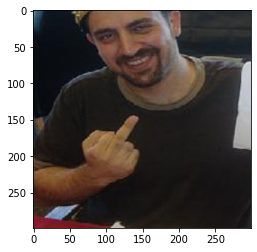

In [132]:
img = Image.open('sample_images/159.250px-Maddoxtacoma.jpg')
image_to_tensor = transform_test(img).unsqueeze(0)
image_to_tensor = image_to_tensor.to(device)
images = image_to_tensor

outputs = model(image_to_tensor.to(device)).cpu()
_, predicted = outputs.max(1)
pred_val = predicted.item()
print("Predicted class: ",pred_val)
inv_tensor = invTrans(image_to_tensor)
plt.imshow( inv_tensor.detach().cpu().squeeze().permute(1, 2, 0)  )

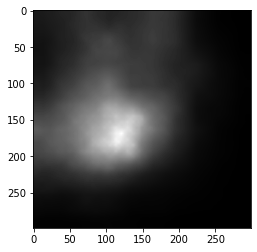

In [133]:
from pytorch_grad_cam import FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
input_tensor = images.to(device)
targets = [ClassifierOutputTarget(0)]
target_layers = [model.layer4[-1]]
cam = FullGrad(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
#visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=T
plt.imshow(grayscale_cam, cmap='gray', vmin=0, vmax=1)

In [134]:
# Use inv_tensor as the original input image, and use grayscale_cam as the attribution map
print(inv_tensor.to('cpu').numpy().shape)
print(grayscale_cam.shape)

(1, 3, 299, 299)
(299, 299)


In [ ]:
#Generic code for implementing pipeline saving
cluster_type = 'dummy'
parent_dir = "/adv_robustness/region_explainability/pipeline"
cluster_dir = os.path.join(parent_dir, cluster_type)


In [276]:
import importlib  
import pyximport
from scikit_image import skimage
import warnings
warnings.filterwarnings('ignore')

In [277]:
np_inv = inv_tensor.to('cpu').numpy()

In [278]:
#grayscale_three = np.repeat([grayscale_cam], 3, axis=0)
#np_combo = np.append(np_inv, [grayscale_three], axis=0)
#np_combo = np.append(np_inv, [[grayscale_cam]], axis=1)
#np_combo = np.insert(np_inv, 0, [[grayscale_cam]], axis=1)

np_combo = np_inv.copy()
#np_combo[0,0] = np.mean(np_combo[0,0:3:2],axis=0)
#print(np_combo[0,1].shape)
np_combo[0,2] = grayscale_cam
np_combo.shape

(1, 3, 299, 299)

In [201]:
with np.printoptions(threshold=np.inf):
    print(np_combo)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [279]:
compactness = 30
num_segments = 25

In [282]:
slic_out = skimage.segmentation.slic(np_inv, n_segments=num_segments, compactness=compactness, start_label=1, channel_axis=1)
slic_combo = skimage.segmentation.slic(np_combo, n_segments=num_segments, compactness=compactness, start_label=1, channel_axis=1)

ModuleNotFoundError: No module named 'scikit_image.skimage.morphology._skeletonize_3d_cy'

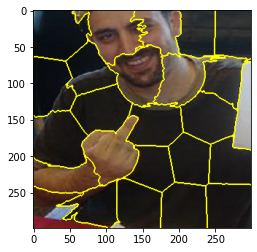

In [228]:
#Basic
plt.imshow(segmentation.mark_boundaries(np.transpose(np.squeeze(np_inv),(1,2,0)), np.squeeze(slic_out)))

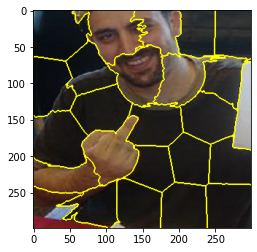

In [228]:
#Basic
plt.imshow(segmentation.mark_boundaries(np.transpose(np.squeeze(np_inv),(1,2,0)), np.squeeze(slic_out)))

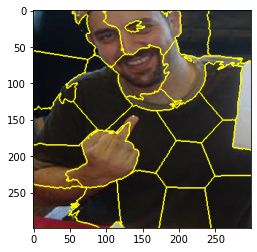

In [235]:
#3D image color dimension
plt.imshow(segmentation.mark_boundaries(np.transpose(np.squeeze(np_inv),(1,2,0)), np.squeeze(slic_combo[0])))

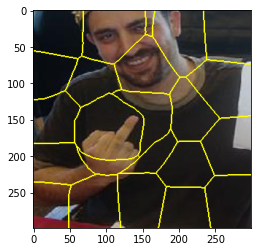

In [236]:
#3D image gradcam dimension
plt.imshow(segmentation.mark_boundaries(np.transpose(np.squeeze(np_inv),(1,2,0)), np.squeeze(slic_combo[1])))

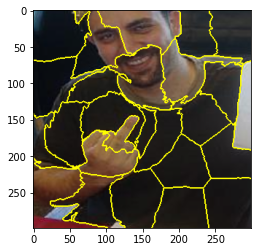

In [255]:
#Replace and overwrite last dimension
plt.imshow(segmentation.mark_boundaries(np.transpose(np.squeeze(np_inv),(1,2,0)), np.squeeze(slic_combo)))

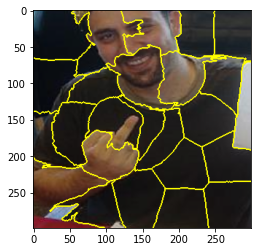

In [246]:
#Replace first dimension average first 2 as second
plt.imshow(segmentation.mark_boundaries(np.transpose(np.squeeze(np_inv),(1,2,0)), np.squeeze(slic_combo)))

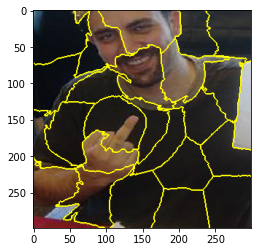

In [249]:
#Replace second dimension average last 2 as third
plt.imshow(segmentation.mark_boundaries(np.transpose(np.squeeze(np_inv),(1,2,0)), np.squeeze(slic_combo)))

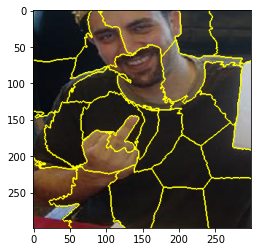

In [252]:
#Replace last dimension average first and last as first
plt.imshow(segmentation.mark_boundaries(np.transpose(np.squeeze(np_inv),(1,2,0)), np.squeeze(slic_combo)))

In [231]:
np.transpose(np.squeeze(np_inv),(1,2,0)).shape

(299, 299, 3)

In [233]:
np.squeeze(slic_combo).shape

(2, 299, 299)

In [238]:
 np.mean(slic_combo, axis=0).shape

(299, 299)